After looking at the visualization here, I believe the countries belong to certain categories but I didn't know how to define the profile of those categories. Still using the same data, I try clustering technique utilizing K-means algorithm.

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import pandas as pd
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

In [88]:
#import dataset
df = pd.read_csv('data/Birthrate_Deathrate_fsi_pop_gdp.csv')

In [89]:
df_2019 = df[(df['Region'].notnull()) & (df['Year'] == 2019) & (df['IncomeGroup'].notnull()) & (df['BirthRate'].notnull()) & (df['DeathRate'].notnull()) 
             & (df['Total'].notnull())]

df_2019.isnull().sum()

CountryName                         0
CountryCode                         0
Year                                0
BirthRate                           0
DeathRate                           0
CountryName_fsi                     0
CountryName_wb                      0
Region                              0
IncomeGroup                         0
Country                             0
Year_fsi                            0
Rank                                0
Total                               0
C1: Security Apparatus              0
C2: Factionalized Elites            0
C3: Group Grievance                 0
E1: Economy                         0
E2: Economic Inequality             0
E3: Human Flight and Brain Drain    0
P1: State Legitimacy                0
P2: Public Services                 0
P3: Human Rights                    0
S1: Demographic Pressures           0
S2: Refugees and IDPs               0
X1: External Intervention           0
Population                          1
GDP         

In [90]:
#change IncomeGroup to integer and store the encoded IncomeGroup to IncomeGroup_enc

le = LabelEncoder()

df_2019['IncomeGroup_enc'] = le.fit_transform(df_2019['IncomeGroup'])

label_encoder = le.fit_transform(df_2019['IncomeGroup'])

#adding derived feature
df_2019['NC'] = df_2019['BirthRate']-df_2019['DeathRate']
df_2019.head()

C:\Users\Lily\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Lily\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


,CountryName,CountryCode,Year,BirthRate,DeathRate,CountryName_fsi,CountryName_wb,Region,IncomeGroup,Country,...,P1: State Legitimacy,P2: Public Services,P3: Human Rights,S1: Demographic Pressures,S2: Refugees and IDPs,X1: External Intervention,Population,GDP,IncomeGroup_enc,NC
28,El Salvador,SLV,2019,18.054,7.070,El Salvador,El Salvador,Latin America & Caribbean,Lower middle income,El Salvador,...,4.2,5.8,5.7,7.0,4.8,5.3,6453550.0,2.689666e+10,2,10.984
88,Equatorial Guinea,GNQ,2019,32.783,9.112,Equatorial Guinea,Equatorial Guinea,Sub-Saharan Africa,Upper middle income,Equatorial Guinea,...,9.8,8.1,8.6,7.9,4.5,4.4,1355982.0,1.141728e+10,3,23.671
148,Eritrea,ERI,2019,29.738,7.012,Eritrea,Eritrea,Sub-Saharan Africa,Low income,Eritrea,...,9.4,7.8,8.7,8.4,7.7,7.0,NaN,NaN,1,22.726
208,Estonia,EST,2019,10.600,11.600,Estonia,Estonia,Europe & Central Asia,High income,Estonia,...,2.1,2.3,1.7,2.2,2.5,3.7,1326898.0,3.104559e+10,0,-1.000
268,Ethiopia,ETH,2019,31.896,6.418,Ethiopia,Ethiopia,Sub-Saharan Africa,Low income,Ethiopia,...,8.0,8.3,8.2,9.0,8.7,7.9,112078727.0,9.591259e+10,1,25.478


In [93]:
#select columns for the analysis
df_2019_withname = df_2019[['CountryName','CountryCode','NC','IncomeGroup','IncomeGroup_enc','Total']]
df_2019_1 = df_2019[['CountryCode','NC','IncomeGroup_enc','Total']]
df_2019_nolabel = df_2019[['NC','IncomeGroup_enc','Total']]

df_2019_nolabel.head()

,NC,IncomeGroup_enc,Total
28,10.984,2,69.8
88,23.671,3,82.6
148,22.726,1,96.4
208,-1.000,0,40.8
268,25.478,1,94.2


In [94]:
df_2019_nolabel.isnull().sum()

NC                 0
IncomeGroup_enc    0
Total              0
dtype: int64

In [95]:
# creating a copy to keep original df as is for later
df_clust = df_2019_nolabel.copy()

cols_scale = df_clust.columns
df_clust.head()

,NC,IncomeGroup_enc,Total
28,10.984,2,69.8
88,23.671,3,82.6
148,22.726,1,96.4
208,-1.000,0,40.8
268,25.478,1,94.2


In [96]:
#Scaling
scaler = MinMaxScaler().fit(df_clust[cols_scale])
df_clust[cols_scale] = scaler.transform(df_clust[cols_scale]);

C:\Users\Lily\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


To determine the number of category, I use charts below and look for the knee with lowest inertia, then choose the one with the highest silhouette coefficients. The number of cluster chosen will be used in K-means algorithm.

In [99]:
kmeans = KMeans(
    init="random",
    n_clusters=6,
    n_init=10,
    max_iter=300,
    random_state=42
)

kmeans.fit(df_clust)

kmeans_kwargs = {"init": "k-means++",
                  "n_init": 10,
                  "max_iter": 300,
                  "random_state": 42}

In [100]:
   # A list holds the SSE values for each k, to plot in elbow plot
   sse = []
   for k in range(1, 11):
       kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
       kmeans.fit(df_clust)
       sse.append(kmeans.inertia_)
    
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_clust)
    score = silhouette_score(df_clust, kmeans.labels_)
    silhouette_coefficients.append(score)

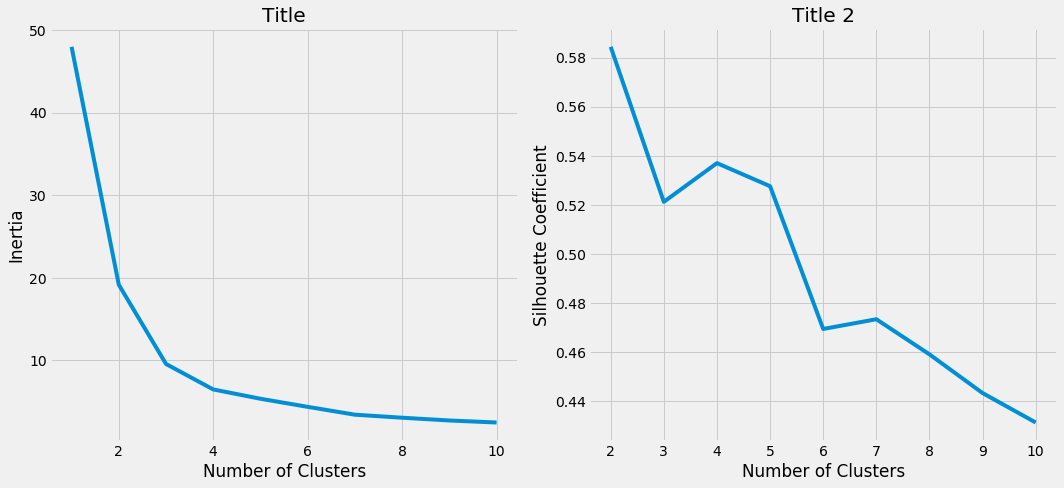

In [101]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
fig.tight_layout(pad=7)
axes[0].plot(range(1, 11), sse)
axes[0].set(title='Title', xlabel='Number of Clusters', 
       ylabel='Inertia')
axes[1].plot(range(2, 11), silhouette_coefficients)
axes[1].set(title='Title 2', xlabel='Number of Clusters', 
       ylabel='Silhouette Coefficient')
fig.tight_layout()

In [97]:
kmeans_1 = KMeans(n_jobs = -1, n_clusters = 5, init='k-means++',random_state=42)
kmeans_1.fit(df_clust)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [102]:
df_2019kmeans_result = df_2019_withname.copy()

df_2019kmeans_result['cluster_ids'] = kmeans_1.labels_

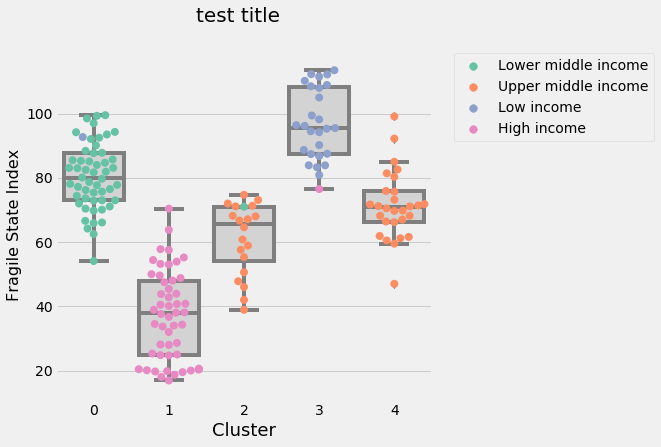

In [60]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(6, 6))
ax = sns.boxplot(x="cluster_ids", y="Total", data=df_2019kmeans_result, color="lightgrey")
ax = sns.swarmplot(x="cluster_ids", y="Total", data=df_2019kmeans_result, hue="IncomeGroup",palette="Set2",size = 8)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.suptitle('test title', fontsize=20)
plt.xlabel('Cluster', fontsize=18)
plt.ylabel('Fragile State Index', fontsize=16)
plt.show()

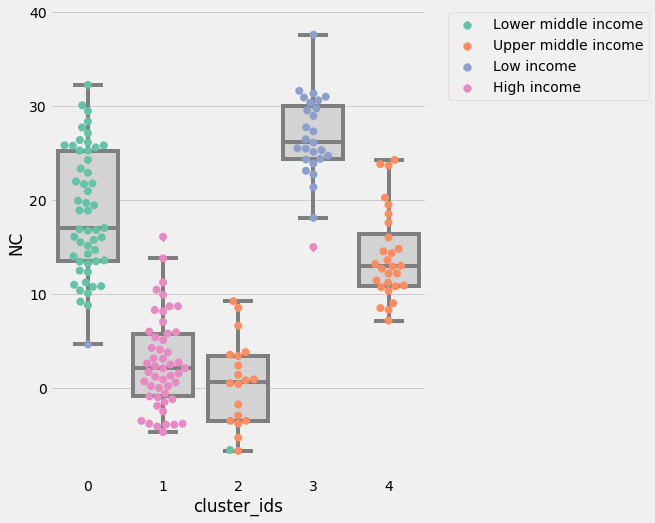

In [81]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(6, 8))

az = sns.boxplot(x="cluster_ids", y="NC", data=df_2019kmeans_result,color="lightgrey")
az = sns.swarmplot(x="cluster_ids", y="NC", data=df_2019kmeans_result, hue="IncomeGroup", palette="Set2",size = 8)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show()

Income category provided by World Bank differentiate countries quite well. Using clusters created by K-means clustering method, the result isn't too far off from World Bank's. The countries stat in the same category except for Upper Middle Income. K-means separated Upper Middle Income into two clusters; one with low Natural Change and lower Fragile State Index and one with both higher Natural Change and Fragile State Index. Table below shows the profile of each cluster.

In [103]:
# Cluster ID level summary
df_2019kmeans_result.groupby('cluster_ids').describe().T.reset_index()

cluster_ids,level_0,level_1,0,1,2,3,4
0,NC,count,53.000000,50.000000,20.000000,27.000000,28.000000
1,NC,mean,18.665528,2.685760,0.373450,26.607111,14.126750
2,NC,std,6.590237,4.859131,4.670429,4.606603,4.737747
3,NC,min,4.643000,-4.700000,-6.700000,15.000000,7.172000
4,NC,25%,13.485000,-0.825000,-3.500000,24.347000,10.881500
5,NC,50%,17.026000,2.100000,0.665000,26.126000,12.962500
6,NC,75%,25.262000,5.700000,3.434500,30.054500,16.416500
7,NC,max,32.251000,16.091000,9.229000,37.604000,24.264000
8,IncomeGroup_enc,count,53.000000,50.000000,20.000000,27.000000,28.000000
9,IncomeGroup_enc,mean,1.981132,0.000000,2.950000,0.962963,3.000000
